In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
import os
import math


In [2]:
def quantimage(image,k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img

#Show img
def plot_img(img,size=(8,8)):
    plt.figure(figsize=size)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# img_path_1="./image/EpiscopalGaudi/3743214471_1b5bbfda98_o.jpg"
# img_path_2="./image/EpiscopalGaudi/4386465943_8cf9776378_o.jpg"
# img_path_3="./image/MountRushmore/9021235130_7c2acd9554_o.jpg"
# img_path_4="./image/EpiscopalGaudi/rotate_20.jpg"

img_path_1="./image/all_image/hand1.jpg"
img_path_2="./image/all_image/hand2.jpg"
img_path_3="./image/all_image/hand3.jpg"
img_path_4="./image/all_image/hand_fake.jpg"
img_path_5="./image/EpiscopalGaudi/4386465943_8cf9776378_o.jpg"
img_path_6="./image/MountRushmore/9021235130_7c2acd9554_o.jpg"

img1=cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB) 
img2=cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB) 
img3=cv2.cvtColor(cv2.imread(img_path_3), cv2.COLOR_BGR2RGB) 
img4=cv2.cvtColor(cv2.imread(img_path_4), cv2.COLOR_BGR2RGB) 
img5=cv2.cvtColor(cv2.imread(img_path_5), cv2.COLOR_BGR2RGB) 
img6=cv2.cvtColor(cv2.imread(img_path_6), cv2.COLOR_BGR2RGB) 

In [39]:
image_folder="./image/all_image/"
for filename in os.listdir(image_folder):
    image_path=os.path.join(image_folder,filename)
    img=cv2.imread(image_path)
    img=quantimage(img,8)
    cv2.imwrite(f"./image/all_quantimage/{filename}",img)
# img=cv2.imread(img_path_1)
# img_rotate=rotate_image(img,20)
# plot_img(img_rotate)
# cv2.imwrite("./image/EpiscopalGaudi/rotate_20.jpg",img_rotate)

In [14]:

# img1=img1
# img1=quantimage(img1,8)
# img1_luv=cv2.cvtColor(np.array(img1).astype('float32')/255, cv2.COLOR_RGB2Luv)
# img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
# plot_img(img1,(8,8))
# plot_img(img2,(8,8))

#### CECH

In [3]:
def get_CECH(image,TH_G=30,d=4,quantization = True):
    if quantization:
        img1=quantimage(image,8)
    #Xám hóa
    img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    
    h,w,c=img1.shape

    img1_luv=cv2.cvtColor(np.array(img1).astype('float32')/255, cv2.COLOR_RGB2Luv)

    pixels = [(*pixel,) for pixel in img1_luv.reshape(-1, 3)]
    color_list=Counter(pixels)
    # img1_pad=np.pad(img1, ((1,1), (1,1),(0,0)), constant_values=0)
    img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    #Sobel
    sobelx = cv2.Sobel(img1_gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img1_gray,cv2.CV_64F,0,1,ksize=3)
        
    e=np.zeros((h,w))
    gradient_f=np.zeros((h,w))
    theta=np.zeros((h,w))
    list_value=[]

    px_1=np.zeros((h,w))
    px_2=np.zeros((h,w))
    py_1=np.zeros((h,w))
    py_2=np.zeros((h,w))

    cout_neg=0
    for i in range(h):
        for j in range(w):
            gradient_f[i][j]=math.sqrt(sobelx[i,j]**2+sobely[i,j]**2)
            theta[i][j]=math.atan(sobely[i,j]/(sobelx[i,j]+0.1))

            if gradient_f[i][j]>TH_G:
                e[i][j]=1
                x1= i - d* math.cos(theta[i][j])
                y1= j + d*math.sin(theta[i][j])
                
                px_1[i][j]=int(x1)
                py_1[i][j]=int(y1)
                x2= i + d* math.cos(theta[i][j])
                y2= j - d*math.sin(theta[i][j])
                px_2[i][j]=int(x2)
                py_2[i][j]=int(y2)
                if x1 <0 or y1 <0 or int(x1) >=h or int(y1) >=w:
                    px_1[i][j]=int(i)
                    py_1[i][j]=int(j)
                    cout_neg+=1
                    
                if x2 <0 or y2 <0 or int(x2) >=h or int(y2) >=w:
                    px_2[i][j]=int(i)
                    py_2[i][j]=int(j)
                    cout_neg+=1
            else:
                e[i][j]=0
    # plot_img(e)
    CECH={}

    for key1 in color_list.keys():
        for key2 in color_list.keys():
            CECH[key1,key2]=0

        
    for i in range(h):
        for j in range(w):
            if e[i][j]==1:
                color_1=img1_luv[int(px_1[i][j])][int(py_1[i][j])]
                color_2=img1_luv[int(px_2[i][j])][int(py_2[i][j])]

                CECH[(color_1[0],color_1[1],color_1[2]),(color_2[0],color_2[1],color_2[2])]+=1
    
    return CECH
    x= [key for key in CECH.keys()]
    y= [CECH[t] for t in x]
    x= [str(key) for key in CECH.keys()]

def color_distance(x1,x2):
    distance=math.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2)
    return distance
    

def compare_CECH(CECH1,CECH2,TH=15):
    keys1=[key for key in CECH1.keys()]
    keys2=[key for key in CECH2.keys()]
    CECH1_sum=sum(CECH1.values())
    CECH2_sum=sum(CECH2.values())
    BW=2.64*TH
    sigma=TH*0.8
    mu=0
    its_list=[]
    its_dict={}
    # dC_list=[]
    for key1 in keys1:
        for key2 in keys2:
            # print(key1)
            ci=key1[0]
            cj=key1[1]

            ck=key2[0]
            cl=key2[1]

            d1=color_distance(ci,ck)
            d2=color_distance(cj,cl)
            dC = max(d1,d2)
            if dC <= BW:
                its= min(CECH1[key1]/CECH1_sum,CECH2[key2]/CECH2_sum)
                new_its=its*math.exp(-(dC**2)/(2*sigma**2))
                its_dict[key1,key2]=new_its
            
    its_dict={k: v for k, v in sorted(its_dict.items(), key=lambda item: item[1],reverse=True)}
    check_list_1=[]
    check_list_2=[]

    for key in its_dict:
        if key[0] in check_list_1 or key[1] in check_list_2:
            continue
        its_list.append(its_dict[key])
        check_list_1.append(key[0])
        check_list_2.append(key[1])
    
    return sum(its_list) 

In [7]:
image_folder="./image/all_image/"

data_all={}
# file_list=[]
for filename in os.listdir(image_folder):
    # file_list.append(filename)
    print(f"Processing: {filename}")
    image_path=os.path.join(image_folder,filename)

    img=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
    CECH=get_CECH(img)

    data_all[filename]=CECH



Processing: 3743214471_1b5bbfda98_o.jpg
Processing: 4191453057_c86028ce1f_o.jpg
Processing: 4386465943_8cf9776378_o.jpg
Processing: 9021235130_7c2acd9554_o.jpg
Processing: 921919841_a30df938f2_o.jpg
Processing: 9318872612_a255c874fb_o.jpg
Processing: hand1.jpg
Processing: hand2.jpg
Processing: hand3.jpg
Processing: hand4.jpg
Processing: hand_fake.jpg
Processing: rotate_20.jpg


UnboundLocalError: local variable 'new_its' referenced before assignment

In [10]:
target_file="hand2.jpg"
result_all={}
for filename in os.listdir(image_folder):
    result_all[filename]=compare_CECH(data_all[target_file],data_all[filename],TH=20)

In [11]:
result_all

{'3743214471_1b5bbfda98_o.jpg': 0.30480492571510936,
 '4191453057_c86028ce1f_o.jpg': 0.39092855804871396,
 '4386465943_8cf9776378_o.jpg': 0.3349671329498048,
 '9021235130_7c2acd9554_o.jpg': 0.3431602782701753,
 '921919841_a30df938f2_o.jpg': 0.38980764962054204,
 '9318872612_a255c874fb_o.jpg': 0.4021857145183167,
 'hand1.jpg': 0.8631906685281653,
 'hand2.jpg': 1.0,
 'hand3.jpg': 0.8486450284560428,
 'hand4.jpg': 0.8304827161238317,
 'hand_fake.jpg': 0.3516826274924872,
 'rotate_20.jpg': 0.3476536110744517}

#### HI

In [2]:
def get_HI(image,quantization = True ):
    if quantization: 
        image=quantimage(image,8)
    plot_img(image,(8,8))
    # h,w,c=img.shape
    pixels = [(*pixel,) for pixel in image.reshape(-1, 3)]
    color_count=Counter(pixels)
    sum_value=sum(color_count.values())
    
    color_list=[(r,g,b) for r in range(0,256) for g in range(0,256) for b in range(0,256)]
    HI={}
    for color in color_list:
        HI[color]=0
    for key in color_count.keys():
        HI[key]=color_count[key]/sum_value
    return HI

def compare_HI(HI1,HI2):
    HI_score=0
    for key in HI1:
        HI_score+=min(HI1[key],HI2[key])

    return HI_score


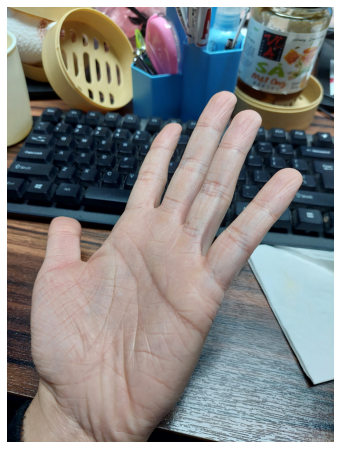

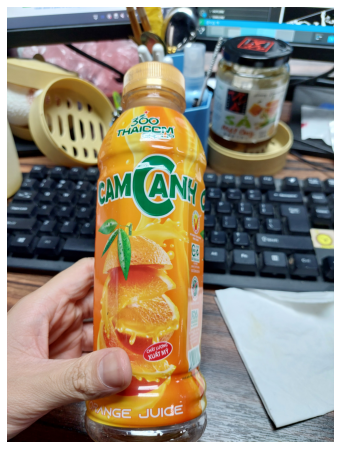

In [14]:
HI1=get_HI(img1)
HI2=get_HI(img4)



In [15]:
compare_HI(HI1,HI2)

0.31419293750477995

####  MPHM

In [1]:
def get_MPHM(image, quantization = True ):
    if quantization:
        image=quantimage(image,8)
    h,w,c=image.shape

    img1_luv=cv2.cvtColor(np.array(image).astype('float32')/255, cv2.COLOR_RGB2Luv)
    pixels = [(*pixel,) for pixel in img1_luv.reshape(-1, 3)]
    GWHI=Counter(pixels)

    sum_value=sum(GWHI.values())
    for key in GWHI.keys():
        GWHI[key]=GWHI[key]/sum_value
    return GWHI

def compare_MPHM(MPHM1,MPHM2,TH=15):
    BW=TH*2.64
    MPHM_score=0
    w_dict={}
    # check_list_1=[]
    # check_list_2=[]
    for key1 in MPHM1:
        for key2 in MPHM2:
            distance=color_distance(key1,key2)
            if distance > TH:
                w=0
            else:
                w=1
            score=w*min(MPHM1[key1],MPHM2[key2])
            w_dict[key1,key2]=score

    w_dict={k: v for k, v in sorted(w_dict.items(), key=lambda item: item[1],reverse=True)}
    w_dict
    w_new={}
    check_list_1=[]
    check_list_2=[]

    for key in w_dict:
        if key[0] in check_list_1 or key[1] in check_list_2:
            continue
        # w_new[key]=w_dict[key]
        MPHM_score+=w_dict[key]
        check_list_1.append(key[0])
        check_list_2.append(key[1])
    # for key in w_new:
    #     GWHI_score+=w_new[key]*min(GWHI1[key[0]],GWHI2[key[1]])
        # GWHI_score+=GWHI_score_tmp
    return MPHM_score


In [14]:
image_folder="./image/all_image/"

data_all={}
# file_list=[]
for filename in os.listdir(image_folder):
    # file_list.append(filename)
    print(f"Processing: {filename}")
    image_path=os.path.join(image_folder,filename)

    img=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
    MPHM=get_MPHM(img)

    data_all[filename]=MPHM



Processing: 3743214471_1b5bbfda98_o.jpg
Processing: 4191453057_c86028ce1f_o.jpg
Processing: 4386465943_8cf9776378_o.jpg
Processing: 9021235130_7c2acd9554_o.jpg
Processing: 921919841_a30df938f2_o.jpg
Processing: 9318872612_a255c874fb_o.jpg
Processing: hand1.jpg
Processing: hand2.jpg
Processing: hand3.jpg
Processing: hand4.jpg
Processing: hand_fake.jpg
Processing: rotate_20.jpg


In [15]:
target_file="hand2.jpg"
result_all={}
for filename in os.listdir(image_folder):
    result_all[filename]=compare_MPHM(data_all[target_file],data_all[filename],TH=15)

In [16]:
result_all

{'3743214471_1b5bbfda98_o.jpg': 0.734714116919691,
 '4191453057_c86028ce1f_o.jpg': 0.791123736743174,
 '4386465943_8cf9776378_o.jpg': 0.9121447765631796,
 '9021235130_7c2acd9554_o.jpg': 0.7125981628911205,
 '921919841_a30df938f2_o.jpg': 0.8397980502577385,
 '9318872612_a255c874fb_o.jpg': 0.7359218258702765,
 'hand1.jpg': 0.9306500510849567,
 'hand2.jpg': 1.0,
 'hand3.jpg': 0.9730438926537436,
 'hand4.jpg': 0.8433268279833814,
 'hand_fake.jpg': 0.7485025597354756,
 'rotate_20.jpg': 0.6925313613627879}

#### GWHI

In [5]:
def get_GWHI(image,quantization = True ):
    if quantization:
        image=quantimage(image,8)
    h,w,c=image.shape

    img1_luv=cv2.cvtColor(np.array(image).astype('float32')/255, cv2.COLOR_RGB2Luv)
    pixels = [(*pixel,) for pixel in img1_luv.reshape(-1, 3)]
    GWHI=Counter(pixels)

    sum_value=sum(GWHI.values())
    for key in GWHI.keys():
        GWHI[key]=GWHI[key]/sum_value
    return GWHI

def compare_GWHI(GWHI1,GWHI2,TH=15):
    BW=TH*2.64
    sigma=TH*0.8
    GWHI_score=0
    w_dict={}
    # check_list_1=[]
    # check_list_2=[]
    for key1 in GWHI1:
        for key2 in GWHI2:
            distance=color_distance(key1,key2)
            if distance > BW:
                w=0
            else:
                w=math.exp(-distance**2/(2*sigma**2))
            score=w*min(GWHI1[key1],GWHI2[key2])
            w_dict[key1,key2]=score

    w_dict={k: v for k, v in sorted(w_dict.items(), key=lambda item: item[1],reverse=True)}
    w_dict
    w_new={}
    check_list_1=[]
    check_list_2=[]

    for key in w_dict:
        if key[0] in check_list_1 or key[1] in check_list_2:
            continue
        # w_new[key]=w_dict[key]
        GWHI_score+=w_dict[key]
        check_list_1.append(key[0])
        check_list_2.append(key[1])
    # for key in w_new:
    #     GWHI_score+=w_new[key]*min(GWHI1[key[0]],GWHI2[key[1]])
        # GWHI_score+=GWHI_score_tmp
    return GWHI_score


### Test all

In [2]:
from all_method import *
import json


In [3]:
image_folder="./image/main_image/"

filename_list=[]
for filename in os.listdir(image_folder):
    filename_list.append(filename)
len(filename_list)

34

In [ ]:
for i in range(len(filename_list)):
    data={}
    # i=4
    filename=filename_list[i]
    name,ext=os.path.splitext(filename)
    print("i: ",i)
    print("Processing: ",filename)

    image_path=os.path.join(image_folder,filename)
    img=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
    img_quanti=quantimage(img,8)

    print("     CECH.....")
    CECH=get_CECH(img_quanti,img,TH_G=30,d=4,quantization = False)

    print("     HI.......")
    HI=get_HI(img, quantization = False)
    print("     GWHI.....")
    GWHI=get_GWHI(img_quanti, quantization = False )
    print("     MPHM.....")
    MPHM=get_MPHM(img_quanti, quantization = False )

    data["id"]=filename
    if "face" in filename:
        data["label"]=1
    else:
        data["label"]=0


    data["CECH"]=str(CECH)
    data["HI"]=str(HI)
    data["GWHI"]=str(GWHI)
    data["MPHM"]=str(MPHM)
    with open(f"./image_result/{name}.json","w") as f:
        json.dump(data,f,ensure_ascii=False)

In [9]:

data["CECH"]=str(CECH)
data["HI"]=str(HI)
data["GWHI"]=str(GWHI)
data["MPHM"]=str(MPHM)
with open(f"./image_result/{name}.json","w") as f:
    json.dump(data,f,ensure_ascii=False)

In [2]:
with open(f"./image_result/face_9.json","r") as f:
    data_target=json.load(f)

In [ ]:
from pprint import pprint
target_image="face_9.jpg"
with open(f"./image_result/face_9.json","r") as f:
    data_target=json.load(f)
    
data_result={}
for filename in filename_list:
    name,ext=os.path.splitext(filename)
    with open(f"./image_result/{name}.json","r") as f:
        data_model=json.load(f)
    # if data_model["label"]==0:
    #     continue
    print("Processing: ",filename)
    # CECH_score=compare_CECH(eval(data_target["CECH"]),eval(data_model["CECH"]))
    # HI_score=compare_HI(eval(data_target["HI"]),eval(data_model["HI"]))
    GWHI_score=compare_GWHI(eval(data_target["GWHI"]),eval(data_model["GWHI"]))
    # MPHM_score=compare_MPHM(eval(data_target["MPHM"]),eval(data_model["MPHM"]))
    data_result[filename]= GWHI_score
                            # {
                            # # "CECH_score":CECH_score,
                            # # "HI_score":HI_score,
                            # "GWHI_score":GWHI_score,
                            # # "MPHM_score":MPHM_score,
                            # "label":data_model["label"]
                            # }

data_result={k: v for k, v in sorted(data_result.items(), key=lambda item: item[1],reverse=True)}

    # break

    # print(x)
    # data= json.loads(f.readlines())

In [7]:
data_result

{'face_9.jpg': 1.0,
 'face_12.jpg': 0.5869095521870707,
 'face_8.jpg': 0.5448957744769294,
 'face_11.jpg': 0.522183299580507,
 '9318872612_a255c874fb_o.jpg': 0.48269182829682805,
 'face_4.jpg': 0.44416941481083705,
 '20221213_045556.jpg': 0.42711316410487987,
 '20221213_045541.jpg': 0.41804041558958843,
 'face_5.jpg': 0.40819924717304173,
 'face_6.jpg': 0.35870481296380136,
 'hand3.jpg': 0.32152850867138083,
 'hand4.jpg': 0.3207232473758755,
 'hand2.jpg': 0.31451296351752317,
 '20221213_045534.jpg': 0.3133913653854378,
 '921919841_a30df938f2_o.jpg': 0.3124641093257467,
 '4191453057_c86028ce1f_o.jpg': 0.2950394456062643,
 '20221213_045607.jpg': 0.2897116196783896,
 'hand1.jpg': 0.2855887707836731,
 '20221213_045522.jpg': 0.280476696780283,
 'face_2.jpg': 0.27540966952828266,
 '9021235130_7c2acd9554_o.jpg': 0.26670892682467917,
 '20221213_045546.jpg': 0.2594833811401296,
 'face_10.jpg': 0.25620836639854433,
 'face_7.jpg': 0.252647727097187,
 'face_3.jpg': 0.24945184718569666,
 'black-dog

In [7]:
eval(x["CECH"])

{((81.90132, 8.644142, 7.10584), (81.90132, 8.644142, 7.10584)): 645124,
 ((81.90132, 8.644142, 7.10584), (70.381195, 13.359628, 10.252323)): 158332,
 ((81.90132, 8.644142, 7.10584), (92.12907, 4.877413, 4.8162394)): 158791,
 ((81.90132, 8.644142, 7.10584), (54.85219, 24.114199, 18.854525)): 13972,
 ((81.90132, 8.644142, 7.10584), (43.538837, 42.03231, 20.292133)): 171,
 ((81.90132, 8.644142, 7.10584), (38.51241, 0.93575436, -2.0568764)): 3701,
 ((81.90132, 8.644142, 7.10584), (24.430912, 1.9633714, -0.9513968)): 893,
 ((81.90132, 8.644142, 7.10584), (11.79549, 0.48149335, 1.1526626)): 227,
 ((70.381195, 13.359628, 10.252323), (81.90132, 8.644142, 7.10584)): 155754,
 ((70.381195, 13.359628, 10.252323),
  (70.381195, 13.359628, 10.252323)): 362244,
 ((70.381195, 13.359628, 10.252323), (92.12907, 4.877413, 4.8162394)): 26173,
 ((70.381195, 13.359628, 10.252323), (54.85219, 24.114199, 18.854525)): 59906,
 ((70.381195, 13.359628, 10.252323), (43.538837, 42.03231, 20.292133)): 999,
 ((70.38

In [2]:

data_all={}
for filename in os.listdir(image_folder):
    print("Processing: ",filename)
    image_path=os.path.join(image_folder,filename)

    img=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
    img_quanti=quantimage(img,8)
    if "face" in filename:
        data_all[filename]={"img":img,
                            "img_quanti":img_quanti,
                            "label":1}    
    else:
        data_all[filename]={"img":img,
                            "img_quanti":img_quanti,
                            "label":0}    


Processing:  face_4.jpg
Processing:  20221213_045541.jpg
Processing:  hand3.jpg
Processing:  hand2.jpg
Processing:  20221213_045613.jpg
Processing:  face_9.jpg
Processing:  20221213_045534.jpg
Processing:  black-dog.jpg
Processing:  4386465943_8cf9776378_o.jpg
Processing:  face_7.jpg
Processing:  hand_fake.jpg
Processing:  face_2.jpg
Processing:  20221213_045525.jpg
Processing:  face_8.jpg
Processing:  4191453057_c86028ce1f_o.jpg
Processing:  face_5.jpg
Processing:  3743214471_1b5bbfda98_o.jpg
Processing:  face_10.jpg
Processing:  20221213_045607.jpg
Processing:  9318872612_a255c874fb_o.jpg
Processing:  9021235130_7c2acd9554_o.jpg
Processing:  20221213_045556.jpg
Processing:  Tour_Eiffel_Wikimedia_Commons.jpg
Processing:  face_3.jpg
Processing:  girl.jpg
Processing:  face_1.jpg
Processing:  face_6.jpg
Processing:  hand4.jpg
Processing:  20221213_045546.jpg
Processing:  20221213_045522.jpg
Processing:  hand1.jpg
Processing:  921919841_a30df938f2_o.jpg


In [ ]:
for filename in data_all.keys():
    print("Processing: ",filename)
    img=data_all[filename]["img"]
    img_quanti=data_all[filename]["img_quanti"]
    print("     CECH.....")
    CECH=get_CECH(img_quanti,img,TH_G=30,d=4,quantization = False)
    print("     HI.......")
    HI=get_HI(img, quantization = False)
    print("     GWHI.....")
    GWHI=get_GWHI(img_quanti, quantization = False )
    print("     MPHM.....")
    MPHM=get_MPHM(img_quanti, quantization = False )

    data_all[filename]["CECH"]=CECH
    data_all[filename]["HI"]=HI
    data_all[filename]["GWHI"]=GWHI
    data_all[filename]["MPHM"]=MPHM


In [ ]:
target_image="face_9.jpg"

data_result={}
for filename in data_all.keys():
    print("Processing: ",filename)
    CECH_score=compare_CECH(data_all[target_image]["CECH"],data_all[filename]["CECH"])
    HI_score=compare_HI(data_all[target_image]["HI"],data_all[filename]["HI"])
    GWHI_score=compare_GWHI(data_all[target_image]["GWHI"],data_all[filename]["GWHI"])
    MPHM_score=compare_MPHM(data_all[target_image]["MPHM"],data_all[filename]["MPHM"])
    data_result[filename]={"CECH_score":CECH_score,
                            "HI_score":HI_score,
                            "GWHI_score":GWHI_score,
                            "MPHM_score":MPHM_score,
                            "label":data_all[filename]["label"]}

: 

In [ ]:
import json
with open(f"result.json","w") as f:
        # f.write(f"[{label}]")
        json.dump(data_result,f,ensure_ascii=False)